In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as unit
from photutils import DAOStarFinder, aperture_photometry, CircularAperture
from astropy.stats import mad_std

In [6]:
fits_dir = "C:\\Users\\premv\\Documents\\acad\\gradschool\\term-3\\Astrotech-I\\Experiments\\Exp-1\\Data\\"
fits_subdir = "Unpolarized\\"

gain = 2.5

7

Amount of polarisation in set 1, p = 0.00769 +/- 0.00121
Angle of polarisation in set 1, theta = 3.5 +/- 4.39
Amount of polarisation in set 2, p = 0.00475 +/- 0.00119
Angle of polarisation in set 2, theta = -18.2 +/- 7.18
Amount of polarisation in set 3, p = 0.00263 +/- 0.0012
Angle of polarisation in set 3, theta = -8.71 +/- 13.0
Amount of polarisation in set 4, p = 0.00358 +/- 0.00119
Angle of polarisation in set 4, theta = 45.9 +/- 9.59
Amount of polarisation in set 5, p = 0.00454 +/- 0.00118
Angle of polarisation in set 5, theta = 11.6 +/- 7.44


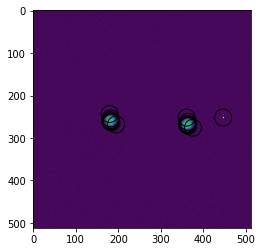

In [7]:
for setno in range(1,6):
    R = {}
    Io = {}
    Ie = {}
    bkgnd = {}
    
    sig_R = {}
    
    
    for alpha in list(range(0,900,900//4)):
    #alpha = 0
        
        fits_filename = "Set{0}_{1}.FIT".format(setno, alpha)
        fits_filepath = fits_dir + fits_subdir + fits_filename
        
        #gc = aplpy.FITSFigure(fits_file)
        
        #gc.show_grayscale()
        
        hdul = fits.open(fits_filepath)
        
        image = np.float64(hdul[0].data)
        hdul.close()
        x_pixels = image.shape[0] * unit.pix
        fwhm = 26.
        r = 20
        bkgnd[alpha] = np.median(image)
        image -= bkgnd[alpha]
        bkg_sigma = mad_std(image)
        daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*bkg_sigma)  
        sources = daofind(image)  
        for col in sources.colnames:  
            sources[col].info.format = '%.8g'  # for consistent table output
#        print(sources)  
        
        positions = np.transpose((sources['xcentroid'],sources['ycentroid']))
        
        apertures = CircularAperture(positions,r=r)
        
        plt.imshow(image)
        apertures.plot()
        
        photo_apertures = aperture_photometry(image, apertures)
#        print(photo_apertures)
        
        Io[alpha] = np.max(photo_apertures['aperture_sum'][photo_apertures['xcenter']<x_pixels/2])
        Ie[alpha] = np.max(photo_apertures['aperture_sum'][photo_apertures['xcenter']>x_pixels/2])
        
    
    
    K = (Io[0]*Io[225]*Io[450]*Io[675])**.25 / (Ie[0]*Ie[225]*Ie[450]*Ie[675])**.25
    
    for alpha in list(range(0,900,900//4)):
        Ie[alpha] *= K
        R[alpha] = (Io[alpha]-Ie[alpha])/(Io[alpha]+Ie[alpha])
        
        Io[alpha] += bkgnd[alpha] * np.pi * r**2
        Ie[alpha] += bkgnd[alpha] * np.pi * r**2
        sig_R[alpha] = ( (4*gain * Io[alpha] * Ie[alpha]) / (Io[alpha] + Ie[alpha])**3 )**.5
        
    q = R[0]    
    u = R[225]
    
    sig_q = sig_R[0]    
    sig_u = sig_R[225]
    
    p = (q**2 + u**2)**.5
    theta = np.arctan2(u,q)/2 * 180 / np.pi
    
    sig_p = ((q**2* sig_q**2 + u**2 * sig_u**2) / (q**2 + u**2))**.5
    sig_theta = ( (q**2* sig_u**2 + u**2 * sig_q**2) / (q**2 + u**2)**2 )**.5 / 2 * 180 / np.pi
    
    
    print ("Amount of polarisation in set {0}, p = {1:.3} +/- {2:.3}".format(setno,p,sig_p) )
    print ("Angle of polarisation in set {0}, theta = {1:.3} +/- {2:.3}".format(setno,theta,sig_theta) )